In [77]:
import pandas as pd
# pd.set_option("display.max_rows", None, "display.max_columns", None)
import os
# pd.set_option('display.max_colwidth', -1)    # stop the column text truncating... 
# pd.set_option("display.max_rows", None, "display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyproj import Geod


# to successfully install geopandas first run ---> pip install pyproj==2.2.0
import geopandas as gp

from shapely.geometry import Point

### CCG Geograhpical Boundaries 

The aim of this notebook is to answer the following questions 

* (Important - answer first) Does the team have the correct CCGs in the inner and outer region?
    * can we check this be inferring a distance from heathrow and checking the ccg boundaries are inside/outside?

* (Later question) Is there a way to have a map with heathrow, CCGs, GPS and the air monitoring stations? 


todo remaining:
* important... --> get lat/longitutes from other airports in LONDON... (and luton?)
* (extended) search for GP lat,long points (what can you use to get lat long points etc) 


DONE 
> * map the airport points on the graph (heathrow etc), copy https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972
> * use pandas... to calculate the different distances from heathrow airport
> * you can then limit ccgs based on the distance from midpoint (given in shape descriptiomn)


Findings:
* discuss East Berkshire

In [ ]:
# Data Source
# https://geoportal.statistics.gov.uk/search?q=clinical%20comissioning%20groups

# MOST USEFUL ONE Mapping with the SHAPE FILES...
# https://towardsdatascience.com/geopandas-101-plot-any-data-with-a-latitude-and-longitude-on-a-map-98e01944b972




# others
# https://towardsdatascience.com/lets-make-a-map-using-geopandas-pandas-and-matplotlib-to-make-a-chloropleth-map-dddc31c1983d
    # accompanying link containing borough files https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london

# overlay midpoint

# this method is quite complicated (try geopandas first as it had a lower barrier of entry & is similar to pandas)
# https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f

        # after... we will need to learn how to put points on the shape file... as a next step 

# https://geoportal.statistics.gov.uk/datasets/clinical-commissioning-groups-april-2019-names-and-codes-in-england
# VECTOR BOUNDARIES AND SHAPE FILES...

# https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0
# * geopandas...

In [54]:
# remember to keep the geometry field truncated... (otherwise this ruins head)
shp_filepath = 'Clinical_Commissioning_Groups__April_2019__Boundaries_EN_BFC-shp/Clinical_Commissioning_Groups__April_2019__Boundaries_EN_BFC.shp'

ldn_map_df = gp.read_file(shp_filepath)

# # check data type so we can see that this is not a normal dataframe, but a GEOdataframe
ldn_map_df.head(10)

# convert the df to lat,long format (required)
ldn_map_df = ldn_map_df.to_crs(epsg=4326)

# altetnaticve way to convert format (see below)
crs = {'init': 'epsg:4326'}

In [61]:
# create airport df so we can visualise them on the map

data = {'LOC_NAME':['Heathrow Airport'],
        'LONG':[-0.454295],
        'LAT': [51.470020],
        'geometry': ['empty'],  
       }
df = pd.DataFrame(data)

# create geometry column
geometry = [Point(xy) for xy in zip(df['LONG'], df['LAT'])]
df.geometry = geometry

# convert the airports df into a geo_df (so that it plots...)
geo_df_airport = gp.GeoDataFrame(df, crs=crs)

geo_df_airport.head()

,LOC_NAME,LONG,LAT,geometry
0,Heathrow Airport,-0.454295,51.47002,POINT (-0.454295 51.47002)


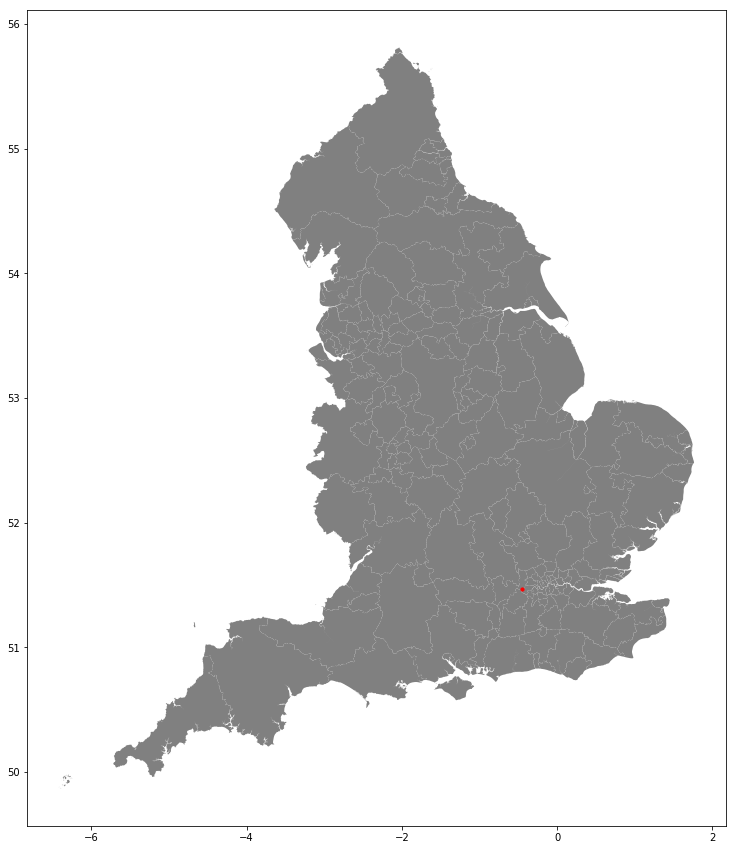

In [76]:
# plot the heathrow airport as a overlay on our ccg map... 

fig, ax = plt.subplots(figsize=(15,15))
ldn_map_df.plot(ax=ax, color='grey',)
geo_df_airport.plot(ax=ax, markersize=10, color='red', marker='o')


## Limit the CCGs

We will now use distancing (from the midpoint of the ccg region), to determine the CCGs to keep around heathrow 

In [80]:
# resources
# https://gis.stackexchange.com/questions/279109/calculate-distance-between-a-coordinate-and-a-county-in-geopandas

ldn_map_df.head()


,OBJECTID,CCG19CD,CCG19NM,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",393990,462191,-2.093300,54.0556,1.220633e+09,222000.154543,POLYGON ((-2.004504131263194 54.17287207348864...
1,2,E38000002,NHS Ashford CCG,597640,140644,0.823374,51.1310,5.806172e+08,149426.082727,"POLYGON ((1.003939402203813 51.18005084706247,..."
2,3,E38000004,NHS Barking and Dagenham CCG,547758,185109,0.129493,51.5455,3.609104e+07,40665.310992,(POLYGON ((0.06912579948535737 51.538811067235...
3,4,E38000005,NHS Barnet CCG,523471,191753,-0.218220,51.6111,8.673644e+07,50842.313101,POLYGON ((-0.1821100786890796 51.6686008286288...
4,5,E38000006,NHS Barnsley CCG,429979,403330,-1.549250,53.5258,3.290521e+08,125518.601736,POLYGON ((-1.348646247507583 53.58331342624416...


In [90]:
# get distance between two lat long points
# https://stackoverflow.com/questions/44446862/calculate-distance-between-latitude-and-longitude-in-dataframe

heathrow_lat, heathrow_lon = 51.47002, -0.454295

# https://pyproj4.github.io/pyproj/stable/api/geod.html
wgs84_geod = Geod(ellps='WGS84') #Distance will be measured on this ellipsoid - more accurate than a spherical method

def get_distance(lat1, lon1, lat2, lon2):
    # distance is returned in metres (cross-checked on site)
    az12,az21,dist = wgs84_geod.inv(lon1,lat1,lon2,lat2) 
    return(dist)
    
def calc_heathrow_dist(row):
    return get_distance(heathrow_lat, heathrow_lon, row['LAT'], row['LONG'])


In [91]:

get_distance(-0.454295, 51.47002,0.129493, 51.5455)

ldn_map_df_dist = ldn_map_df.copy()

ldn_map_df_dist['heathrow_distance'] = ldn_map_df_dist.apply(calc_heathrow_dist, axis=1)

In [92]:
ldn_map_df_dist.head()

,OBJECTID,CCG19CD,CCG19NM,BNG_E,BNG_N,LONG,LAT,Shape__Are,Shape__Len,geometry,heathrow_distance
0,1,E38000001,"NHS Airedale, Wharfedale and Craven CCG",393990,462191,-2.093300,54.0556,1.220633e+09,222000.154543,POLYGON ((-2.004504131263194 54.17287207348864...,308245.341033
1,2,E38000002,NHS Ashford CCG,597640,140644,0.823374,51.1310,5.806172e+08,149426.082727,"POLYGON ((1.003939402203813 51.18005084706247,...",96760.747562
2,3,E38000004,NHS Barking and Dagenham CCG,547758,185109,0.129493,51.5455,3.609104e+07,40665.310992,(POLYGON ((0.06912579948535737 51.538811067235...,41392.357632
3,4,E38000005,NHS Barnet CCG,523471,191753,-0.218220,51.6111,8.673644e+07,50842.313101,POLYGON ((-0.1821100786890796 51.6686008286288...,22685.542828
4,5,E38000006,NHS Barnsley CCG,429979,403330,-1.549250,53.5258,3.290521e+08,125518.601736,POLYGON ((-1.348646247507583 53.58331342624416...,240535.635808


/opt/conda/lib/python3.6/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  super(GeoDataFrame, self).__setitem__(key, value)


['NHS Brent CCG' 'NHS Ealing CCG' 'NHS Hammersmith and Fulham CCG'
 'NHS Harrow CCG' 'NHS Hillingdon CCG' 'NHS Hounslow CCG'
 'NHS Kingston CCG' 'NHS North West Surrey CCG' 'NHS Richmond CCG'
 'NHS East Berkshire CCG']


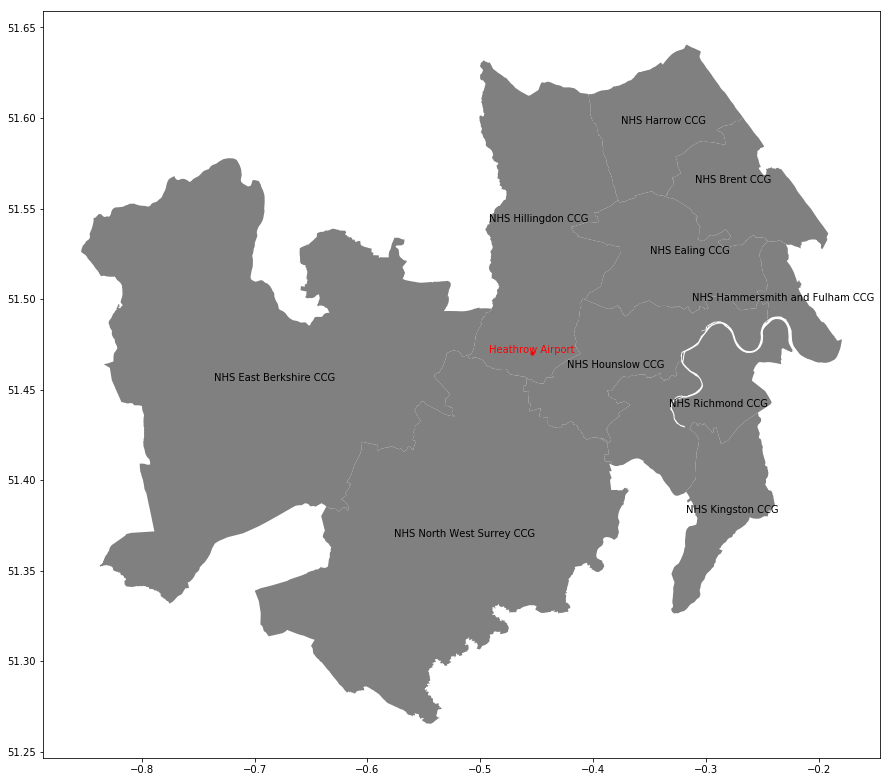

In [115]:
smaller_df = ldn_map_df_dist[ldn_map_df_dist['heathrow_distance'] <= 17500]

# solution inspired by stackoverflow. can also use (long,lat) as the midpoint
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
smaller_df['coords'] = smaller_df['geometry'].apply(lambda x: x.representative_point().coords[:])
smaller_df['coords'] = [coords[0] for coords in smaller_df['coords']]


fig, ax = plt.subplots(figsize=(15,15))
smaller_df.plot(ax=ax, color='grey',)
geo_df_airport.plot(ax=ax, markersize=10, color='red', marker='o')

# plot the names on the midpoints
for idx, row in smaller_df.iterrows():
    plt.annotate(s=row['CCG19NM'], xy=row['coords'],
                 horizontalalignment='center')
    
# do the same for the airports (complete airport_df tomorrow)    
for idx, row in geo_df_airport.iterrows():
    plt.annotate(s=row['LOC_NAME'], xy=((row['LONG'], row['LAT'])),
                 horizontalalignment='center', color='red')
    

print(smaller_df.CCG19NM.unique())


In [ ]:
inner_ccgs = ['NHS Buckinghamshire CCG', 'NHS Ealing CCG', 'NHS East Berkshire CCG', 'NHS Hillingdon CCG',
 'NHS Hounslow CCG', 'NHS North West Surrey CCG']

outer_ccgs =  ['NHS Basildon And Brentwood CCG', 'NHS Berkshire West CCG', 'NHS Brent CCG', 'NHS Croydon CCG',
               'NHS Guildford and Waverley CCG', 'NHS Hammersmith And Fulham CCG', 'NHS Harrow CCG', 
               'NHS Herts Valleys CCG', 'NHS Kingston CCG', 'NHS Merton CCG', 'NHS Oxfordshire CCG', 
               'NHS Richmond CCG', 'NHS Surrey Heath CCG', 'NHS Sutton CCG', 'NHS Wandsworth CCG']